In [1]:
from glob import glob
import os
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
from enum import Enum
import json
import pandas as pd
import seaborn as sns

In [2]:
DEPS_SYNTHESIS_PATH = '../experiments/synthesis/dependency/'
PLAIN_SYNTHESIS_PATH = '../experiments/synthesis/plain/'

In [3]:
class Status(Enum):
    ERROR = "Error"
    SUCCESS = "Success"
    NOT_FOUND = "Not Found"
    TIMEOUT = "Timeout"
    
    def __repr__(self):
        return str(self.value)
    
    def __str__(self):
        return str(self.value)

In [4]:
def get_all_benchmarks(path):
    hoa_files = glob(os.path.join(path, "*.hoa"))
    names = [
        Path(f).stem
        for f in hoa_files
    ]
    return names

print("Total benchmark with Deps Synthesis" , len(get_all_benchmarks(DEPS_SYNTHESIS_PATH)))
print("Total benchmark with Plain Synthesis" , len(get_all_benchmarks(PLAIN_SYNTHESIS_PATH)))

Total benchmark with Deps Synthesis 202
Total benchmark with Plain Synthesis 202


In [5]:
def extract_vars_from_str(x):
    if len(x) == 0:
        return []
    return x.split(",")

In [6]:
def get_benchmark_name(idx):
    path = "../tools/scripts/benchmarks/{}.txt".format(idx)
    with open(path, 'r') as file:
        name = file.readline().replace("\n", "")
    return name
print(get_benchmark_name(2))

EnemeyModule


In [7]:
def benchmark_loader(path: str, idx: str):
    base = {
        'id': idx,
        'Name': get_benchmark_name(idx),
    }
    
    hoa_path = os.path.join(path, idx + ".hoa")
    json_path = os.path.join(path, idx + ".json")
    
    if not os.path.exists(hoa_path):
        return {
            **base,
            'Status': Status.NOT_FOUND
        }
        
    if not os.path.exists(json_path):
        with open(hoa_path, 'r') as f:
            content = f.readlines()
            if 'DUE TO TIME LIMIT' in "\n".join(content):
                return {
                    **base,
                    'Status': Status.TIMEOUT,
                }
            
            return {
                **base,
                'Status': Status.ERROR,
                'Error': content[0]
                
            }
    
    with open(json_path, 'r') as f:
        content = f.readlines()
        try:
            benchmark_json = json.loads(content[0])
        except Exception as e:
            return {
                **base,
                'Status': Status.ERROR,
                'Error': content
            }
    
    # Generic Benchmark Name
    output_vars = benchmark_json['output_vars']
    is_completed = benchmark_json['is_completed']
    total_duration = benchmark_json['total_time']
    
    if not is_completed:
        return {
            **base,
            'Status': Status.TIMEOUT,
            'Is Completed': is_completed,
            'Total Duration': total_duration
        }
    
    # Automaton Build
    is_automaton_build = benchmark_json['automaton']['is_built']
    automaton_build_duration = benchmark_json['automaton']['build_duration']
    total_states = benchmark_json['automaton']['prune_total_states']
    total_edges = benchmark_json['automaton']['total_edges']
    total_output_vars = len(benchmark_json['output_vars'])
    
    # Synthesis
    realizability = benchmark_json['synthesis']['independent_strategy']['realizability']
    indeps_synthesis_duration = benchmark_json['synthesis']['independent_strategy']['duration']
    deps_synthesis_duration = benchmark_json['synthesis']['dependent_strategy']['duration']
    
    # Unateness
    skipped_unate = benchmark_json['unate']['skipped_unate']
    if skipped_unate:
        total_unate_duration = None
        automaton_postprocessing_duration = None
        removed_states = None
        removed_edges = None
    else:
        total_unate_duration = benchmark_json['unate']['total_unate_duration']
        automaton_postprocessing_duration = benchmark_json['unate']['automaton_postprocess_duration']
        removed_states = total_states - benchmark_json['unate']['total_states_after_unate']
        removed_edges = total_edges - benchmark_json['unate']['total_edges_after_unate']

    vars_positive_unates = { var: 0 for var in output_vars }
    vars_negative_unates = { var: 0 for var in output_vars }
    vars_unknown_unates = { var: 0 for var in output_vars }
    state_positive_unates = { state: 0 for state in range(total_states) }
    state_negative_unates = { state: 0 for state in range(total_states) }
    states_not_unates = { state: 0 for state in range(total_states) }
    states_unknown_unates = { state: 0 for state in range(total_states) }
    states_complement_duration = { state: 0 for state in range(total_states) }
    states_complement_failed = { state: None for state in range(total_states) }
    states_removed_edges = { state: 0 for state in range(total_states) }
    states_impacted_edges = { state: 0 for state in range(total_states) }
    
    for state_unateness in benchmark_json['unate'].get('unate_states',[]):
        state = state_unateness['state']
        state_positive_vars = extract_vars_from_str(state_unateness['positive_unate_variables'])
        state_negative_vars = extract_vars_from_str(state_unateness['negative_unate_variables'])
        state_not_unates = extract_vars_from_str(state_unateness['not_unate_variables'])
        state_unknown_unates = extract_vars_from_str(state_unateness['unknown_unate_variables'])
        assert set(state_positive_vars).isdisjoint(set(state_negative_vars))
        
        states_removed_edges[state] = state_unateness['removed_edges']
        states_impacted_edges[state] = state_unateness['impacted_edges']
        
        states_complement_duration[state] = state_unateness['complement_duration']
        states_complement_failed[state] = not state_unateness['complement_succeeded']
        
        for var in state_positive_vars:
            vars_positive_unates[var] += 1
            state_positive_unates[state] += 1
        
        for var in state_negative_vars:
            vars_negative_unates[var] += 1
            state_negative_unates[state] += 1
            
        for var in state_unknown_unates:
            vars_unknown_unates[var] += 1
            states_unknown_unates[state] += 1
    
    # Dependency
    skipped_dependency = benchmark_json['dependency']['skipped_dependencies']
    find_dependency_duration = benchmark_json['dependency']['total_duration']
    total_dependent_vars = 0
    total_independent_vars = 0
    for tested_dependency in benchmark_json["dependency"]['tested_dependencies']:
        is_dependent = tested_dependency['is_dependent']
        if is_dependent:
            total_dependent_vars += 1
        else:
            total_independent_vars += 1
        
    synthesis_duration = indeps_synthesis_duration
    if total_dependent_vars > 0:
        synthesis_duration += deps_synthesis_duration
    
    return {
        # Group 1: General
        **base,
        'Status': Status.SUCCESS,
        'Is Completed': is_completed,
        'Total Duration': total_duration,
        'Realizability': realizability,
        'Applied Unate': not skipped_unate,
        'Applied Dependency': not skipped_dependency,
        'Independent Strategy Gates': benchmark_json['synthesis']['independent_strategy']['total_gates'],
        'Independent Synthesis Duration': indeps_synthesis_duration,
        'Dependent Synthesis Duration': deps_synthesis_duration,
        'Synthesis Duration': synthesis_duration,
        
        # Group 2: Automaton
        'Is Automaton Built': is_automaton_build,
        'Automaton Build Duration': automaton_build_duration,
        'Total Output Vars': total_output_vars,
        'Original Total States': total_states,
        'Original Total Edges': total_edges,
        
        # Unate Impactness
        'Total Unate Duration': total_unate_duration,
        'Automaton Postprocessing Duration': automaton_postprocessing_duration,
        'Total Impacted Edges': sum(states_impacted_edges.values()),
        'Total Removed Edges': sum(states_removed_edges.values()),

        # Group 3: Unates by States
        'States Failed by Complement': sum(1 for val in states_complement_failed.values() if val),
        'Total Complement Duration': sum(val for val in states_complement_duration.values()),
        'Total State with Positive Unates': sum(1 for val in state_positive_unates.values() if val > 0),
        'Total State with Negative Unates': sum(1 for val in state_negative_unates.values() if val > 0),
        'Total State with Unknown Unates': sum(1 for val in states_unknown_unates.values() if val > 0),
        
        # Group 4: Unates by Vars
        'Total Positive Unates Vars (At least 1)': sum(1 for val in vars_positive_unates.values() if val > 0),
        'Total Negative Unates Vars (At least 1)': sum(1 for val in vars_negative_unates.values() if val > 0),
        'Total Positive Unates Vars (All)': sum(1 for val in vars_positive_unates.values() if val == total_states),
        'Total Negative Unates Vars (All)': sum(1 for val in vars_negative_unates.values() if val == total_states),
        
        # Dependency
        'Total Dependent Variables': total_dependent_vars,
        'Total Independent Variables': total_independent_vars,
        'Dependency Ratio': total_dependent_vars / total_output_vars,
        'Find Dependency Duration': find_dependency_duration,
        'Find Dependency Completed': find_dependency_duration != -1,
    }

In [8]:
dependents_synthesis_df = pd.DataFrame([
    benchmark_loader(DEPS_SYNTHESIS_PATH, name)
    for name in get_all_benchmarks(DEPS_SYNTHESIS_PATH)
])
dependents_synthesis_df.sort_values(by=['Name'], ascending=True, inplace=True)
dependents_synthesis_df.head(5)
# dependents_synthesis_df.to_csv('./dependents.csv', index=False)

,id,Name,Status,Is Completed,Total Duration,Realizability,Applied Unate,Applied Dependency,Independent Strategy Gates,Independent Synthesis Duration,...,Total Positive Unates Vars (At least 1),Total Negative Unates Vars (At least 1),Total Positive Unates Vars (All),Total Negative Unates Vars (All),Total Dependent Variables,Total Independent Variables,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Error
61,151,01,Success,True,11.0,REALIZABLE,False,True,88.0,2.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,True,NaN
22,141,02,Success,True,94.0,REALIZABLE,False,True,92.0,52.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,23.0,True,NaN
35,140,03,Success,True,3401.0,REALIZABLE,False,True,122.0,1810.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1497.0,True,NaN
15,143,05,Success,True,2050194.0,REALIZABLE,False,True,191.0,1175619.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,873661.0,True,NaN
175,149,06,Error,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Runtime error: Too many acceptance sets used. ...


In [9]:
plain_synthesis_df = pd.DataFrame([
    benchmark_loader(PLAIN_SYNTHESIS_PATH, name)
    for name in get_all_benchmarks(PLAIN_SYNTHESIS_PATH)
])
plain_synthesis_df.sort_values(by=['Name'], ascending=True, inplace=True)
plain_synthesis_df.head(4)
# plain_synthesis_df.to_csv('./plain.csv', index=False)

,id,Name,Status,Is Completed,Total Duration,Realizability,Applied Unate,Applied Dependency,Independent Strategy Gates,Independent Synthesis Duration,...,Total Positive Unates Vars (At least 1),Total Negative Unates Vars (At least 1),Total Positive Unates Vars (All),Total Negative Unates Vars (All),Total Dependent Variables,Total Independent Variables,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Error
61,151,01,Success,True,8.0,REALIZABLE,False,False,88.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,False,NaN
22,141,02,Success,True,63.0,REALIZABLE,False,False,92.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,False,NaN
35,140,03,Success,True,1858.0,REALIZABLE,False,False,122.0,1769.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,False,NaN
15,143,05,Success,True,1084425.0,REALIZABLE,False,False,191.0,1083530.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,False,NaN


# Summary Results

In [10]:
common_fields = ['Name', 'Status','Is Completed','Total Duration','Realizability','Automaton Build Duration','Synthesis Duration']
dependency_fields = [
    'id',
    'Name',
    'Total Output Vars',
    'Total Dependent Variables',
    'Total Independent Variables',
    'Dependency Ratio',
    'Find Dependency Duration',
    'Find Dependency Completed'
]
synthesis_df = pd.merge(
    plain_synthesis_df[common_fields],
    dependents_synthesis_df[common_fields],
    suffixes=(' (Plain)', ' (Deps)'),
    on='Name',
    how="outer"
)
synthesis_df = pd.merge(
    dependents_synthesis_df[dependency_fields],
    synthesis_df,
    on='Name',
)
synthesis_df.to_csv('./synthesis_summary.csv', index=False)
synthesis_df

,id,Name,Total Output Vars,Total Dependent Variables,Total Independent Variables,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Status (Plain),Is Completed (Plain),Total Duration (Plain),Realizability (Plain),Automaton Build Duration (Plain),Synthesis Duration (Plain),Status (Deps),Is Completed (Deps),Total Duration (Deps),Realizability (Deps),Automaton Build Duration (Deps),Synthesis Duration (Deps)
0,151,01,3.0,0.0,3.0,0.000000,0.0,True,Success,True,8.0,REALIZABLE,5.0,2.0,Success,True,11.0,REALIZABLE,7.0,2.0
1,141,02,4.0,0.0,4.0,0.000000,23.0,True,Success,True,63.0,REALIZABLE,13.0,48.0,Success,True,94.0,REALIZABLE,16.0,52.0
2,140,03,5.0,0.0,5.0,0.000000,1497.0,True,Success,True,1858.0,REALIZABLE,85.0,1769.0,Success,True,3401.0,REALIZABLE,88.0,1810.0
3,143,05,5.0,0.0,5.0,0.000000,873661.0,True,Success,True,1084425.0,REALIZABLE,882.0,1083530.0,Success,True,2050194.0,REALIZABLE,865.0,1175619.0
4,149,06,NaN,NaN,NaN,NaN,NaN,NaN,Error,NaN,NaN,NaN,NaN,NaN,Error,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,174,ltl2dpa20,2.0,1.0,1.0,0.500000,0.0,True,Success,True,8.0,REALIZABLE,4.0,3.0,Success,True,190.0,REALIZABLE,3.0,2.0
198,173,ltl2dpa21,3.0,1.0,2.0,0.333333,1.0,True,Success,True,11.0,REALIZABLE,3.0,7.0,Success,True,250.0,REALIZABLE,3.0,6.0
199,157,ltl2dpa22,NaN,NaN,NaN,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,NaN,Timeout,NaN,NaN,NaN,NaN,NaN
200,154,ltl2dpa23,2.0,1.0,1.0,0.500000,0.0,True,Success,True,6.0,REALIZABLE,1.0,4.0,Success,True,228.0,REALIZABLE,1.0,2.0


# Sanity Checks

## Applied Dependency

In [11]:
fields = ["Applied Unate", "Applied Dependency"]
dependents_synthesis_df[
    ((dependents_synthesis_df["Applied Unate"] != False)
    | (dependents_synthesis_df["Applied Dependency"] != True))
    & (dependents_synthesis_df["Status"] == Status.SUCCESS)
]

,id,Name,Status,Is Completed,Total Duration,Realizability,Applied Unate,Applied Dependency,Independent Strategy Gates,Independent Synthesis Duration,...,Total Positive Unates Vars (At least 1),Total Negative Unates Vars (At least 1),Total Positive Unates Vars (All),Total Negative Unates Vars (All),Total Dependent Variables,Total Independent Variables,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Error


In [12]:
fields = ["Applied Unate", "Applied Dependency"]
plain_synthesis_df[
    ((plain_synthesis_df["Applied Unate"] != False)
    | (plain_synthesis_df["Applied Dependency"] != False))
    & (plain_synthesis_df["Status"] == Status.SUCCESS)
]

,id,Name,Status,Is Completed,Total Duration,Realizability,Applied Unate,Applied Dependency,Independent Strategy Gates,Independent Synthesis Duration,...,Total Positive Unates Vars (At least 1),Total Negative Unates Vars (At least 1),Total Positive Unates Vars (All),Total Negative Unates Vars (All),Total Dependent Variables,Total Independent Variables,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Error


## No Realizability Contradication

In [13]:
realizability_df = pd.merge(
    plain_synthesis_df[["Name", "Realizability"]],
    dependents_synthesis_df[["Name", "Realizability"]],
    suffixes=('_plain', '_dependents'),
    on='Name'
)
realizability_df.head(2)

,Name,Realizability_plain,Realizability_dependents
0,01,REALIZABLE,REALIZABLE
1,02,REALIZABLE,REALIZABLE


In [14]:
not_common_realizable = realizability_df[
    ((realizability_df["Realizability_plain"] == "REALIZABLE") & (realizability_df["Realizability_dependents"] != "REALIZABLE")) | 
    ((realizability_df["Realizability_plain"] != "REALIZABLE") & (realizability_df["Realizability_dependents"] == "REALIZABLE"))
]
not_common_realizable

,Name,Realizability_plain,Realizability_dependents
40,LedMatrix,NaN,REALIZABLE


## All DataFrame has same order

In [15]:
def verify_name_order(*dataframes):
    for i in range(1, len(dataframes)):
        if not dataframes[i - 1]['Name'].equals(dataframes[i]['Name']):
            return False
    return True

In [16]:
verify_name_order(
    plain_synthesis_df,
    dependents_synthesis_df,
)

True

## Different Statuses

In [17]:
synthesis_df[
    synthesis_df['Status (Plain)'] != synthesis_df['Status (Deps)']
]

,id,Name,Total Output Vars,Total Dependent Variables,Total Independent Variables,Dependency Ratio,Find Dependency Duration,Find Dependency Completed,Status (Plain),Is Completed (Plain),Total Duration (Plain),Realizability (Plain),Automaton Build Duration (Plain),Synthesis Duration (Plain),Status (Deps),Is Completed (Deps),Total Duration (Deps),Realizability (Deps),Automaton Build Duration (Deps),Synthesis Duration (Deps)
40,40,LedMatrix,27.0,11.0,16.0,0.407407,1297.0,True,Timeout,NaN,NaN,NaN,NaN,NaN,Success,True,27153.0,REALIZABLE,853.0,23900.0


# Insights

In [18]:

avg_duration_with_dependents = synthesis_df['Total Duration (Deps)'].mean()
avg_duration_without_dependents = synthesis_df['Total Duration (Plain)'].mean()

print('Average duration with dependents:', avg_duration_with_dependents)
print('Average duration without dependents:', avg_duration_without_dependents)

Average duration with dependents: 14529.202127659575
Average duration without dependents: 20760.909090909092


In [19]:
avg_dependency_ratio = synthesis_df['Dependency Ratio'].mean()
min_dependency_ratio = synthesis_df['Dependency Ratio'].min()
max_dependency_ratio = synthesis_df['Dependency Ratio'].max()
std_dependency_ratio = synthesis_df['Dependency Ratio'].std()

print('Average dependency ratio:', avg_dependency_ratio)
print('Minimum dependency ratio:', min_dependency_ratio)
print('Maximum dependency ratio:', max_dependency_ratio)
print('Standard deviation of dependency ratio:', std_dependency_ratio)


Average dependency ratio: 0.3102549974773066
Minimum dependency ratio: 0.0
Maximum dependency ratio: 1.0
Standard deviation of dependency ratio: 0.2660852171113615


In [20]:
synthesis_df['Synthesis Duration Difference'] = synthesis_df['Total Duration (Deps)'] - synthesis_df['Total Duration (Plain)']
correlation = synthesis_df[['Dependency Ratio', 'Synthesis Duration Difference']].corr().iloc[0, 1]

print('Correlation between dependency ratio and duration difference:', correlation)

Correlation between dependency ratio and duration difference: -0.06711180470639745


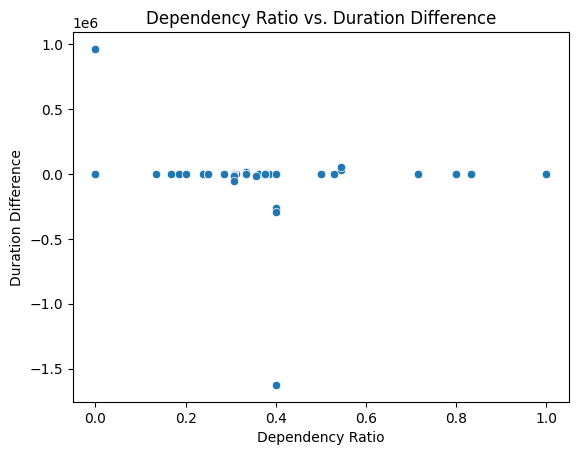

In [21]:
sns.scatterplot(data=synthesis_df, x='Dependency Ratio', y='Synthesis Duration Difference')
plt.title('Dependency Ratio vs. Duration Difference')
plt.xlabel('Dependency Ratio')
plt.ylabel('Duration Difference')
plt.show()


In [22]:
# You can adjust the bin edges according to your data distribution
bins = [0, 0.25, 0.5, 0.75, 1]
labels = ['Low', 'Low-Medium', 'Medium-High', 'High']
synthesis_df['Dependency Group'] = pd.cut(synthesis_df['Dependency Ratio'], bins=bins, labels=labels)

grouped_df = synthesis_df.groupby('Dependency Group').agg({
    'Total Duration (Deps)': 'mean',
    'Total Duration (Plain)': 'mean'
})

print(grouped_df)

                  Total Duration (Deps)  Total Duration (Plain)
Dependency Group                                               
Low                          511.300000               24.100000
Low-Medium                  5500.903846            27105.368932
Medium-High                18447.200000              574.200000
High                         385.266667                2.266667


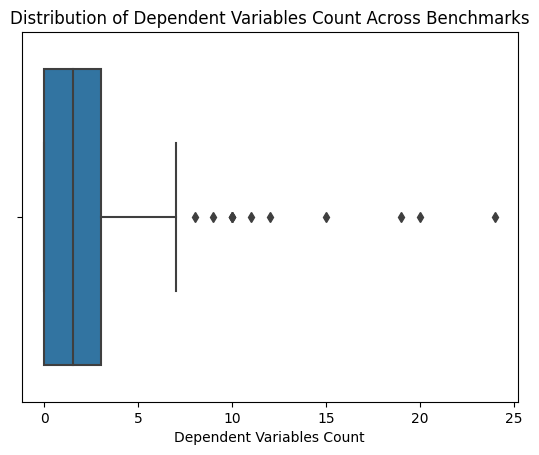

In [23]:
sns.boxplot(data=synthesis_df, x='Total Dependent Variables')
plt.title('Distribution of Dependent Variables Count Across Benchmarks')
plt.xlabel('Dependent Variables Count')
plt.show()


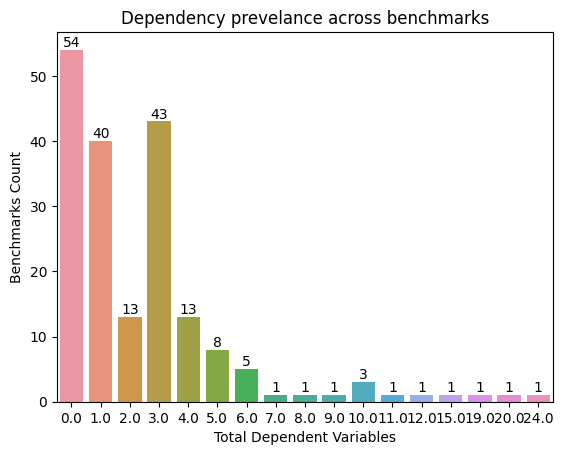

In [42]:
ax = sns.countplot(data=synthesis_df, x='Total Dependent Variables')
ax.bar_label(ax.containers[0]);
ax.set_title('Dependency prevelance across benchmarks');
ax.set_ylabel('Benchmarks Count');

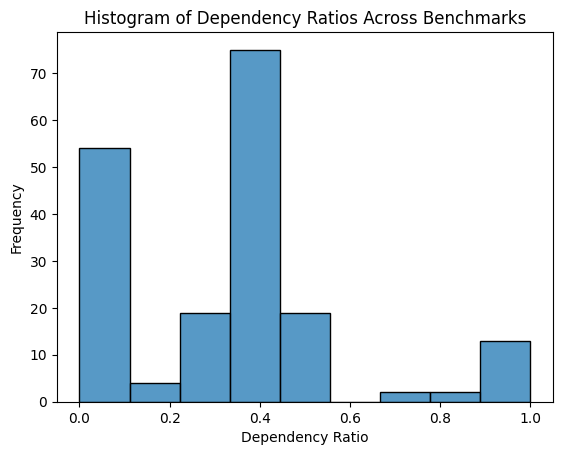

In [48]:
# ax = sns.countplot(data=synthesis_df, x='Dependency Ratio')
# ax.bar_label(ax.containers[0]);
# ax.set_title('Dependency prevelance across benchmarks');
# ax.set_ylabel('Benchmarks Count');
sns.histplot(data=synthesis_df, x='Dependency Ratio', bins='auto', kde=False)
plt.title('Histogram of Dependency Ratios Across Benchmarks')
plt.xlabel('Dependency Ratio')
plt.ylabel('Frequency')
plt.show()

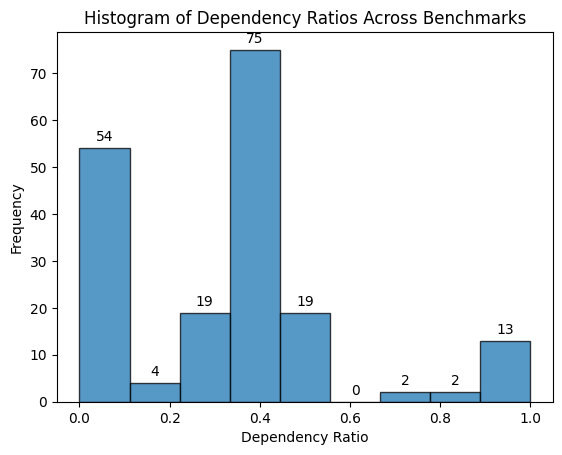

In [49]:
# Assuming your DataFrame is named 'df' and the column with dependency ratio is named 'Dependency Ratio'
fig, ax = plt.subplots()

# Create the histogram using Matplotlib's hist function
n, bins, patches = ax.hist(synthesis_df['Dependency Ratio'], bins='auto', edgecolor='black', alpha=0.75)

# Iterate through the patches (bars) and add labels above each bar
for patch in patches:
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2
    label = f'{int(height)}'
    ax.annotate(label, (x, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.title('Histogram of Dependency Ratios Across Benchmarks')
plt.xlabel('Dependency Ratio')
plt.ylabel('Frequency')
plt.show()
